In [151]:
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', -1)
import pandas_profiling
from sklearn.impute import SimpleImputer
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit,cross_val_score, cross_validate
import itertools 


In [152]:
# Грузим данные
def load_data():
    df_application_train = pd.read_csv('application_train.csv')
    df_application_test = pd.read_csv('application_test.csv')
    print (df_application_train.info())
    print (df_application_test.info())
    return df_application_train, df_application_test

In [175]:
df_application_train, df_application_test = load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


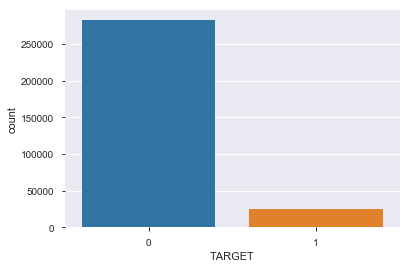

In [154]:
ax = sns.countplot(x = "TARGET" , data= df_application_train )
## Приличный дисбаланс классов. В будущем надо будет делать семплинг

In [155]:
# Посмотрим описание колонок
df_col_desc = pd.read_csv("HomeCredit_columns_description.csv", encoding = 'cp1251')
df_col_desc[df_col_desc['Table'] == 'application_{train|test}.csv'][['Row','Description']]

,Row,Description
0,SK_ID_CURR,ID of loan in our sample
1,TARGET,"Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)"
2,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving
3,CODE_GENDER,Gender of the client
4,FLAG_OWN_CAR,Flag if the client owns a car
5,FLAG_OWN_REALTY,Flag if client owns a house or flat
6,CNT_CHILDREN,Number of children the client has
7,AMT_INCOME_TOTAL,Income of the client
8,AMT_CREDIT,Credit amount of the loan
9,AMT_ANNUITY,Loan annuity


In [156]:
# Подгтовим данные к анализу, для генерации фичей и их предобработки объеденим трейн и тест и удалим таргет

def prepare_for_analisys():
    y = df_application_train[['TARGET','SK_ID_CURR']]
    df_application_train.drop(columns=['TARGET'] , inplace = True)
   # df_application_test.drop(columns=['SK_ID_CURR'] , inplace = True)
    df_application_train['isTrain'] = 1
    df_application_test['isTrain'] = 0
    df = pd.concat([df_application_train, df_application_test], axis = 0, ignore_index = True)
    return y, df

y, df = prepare_for_analisys()

In [157]:
## Функция для генерации списков фичей качественных и количественных
def get_vars(df):
    cat_vars = df.select_dtypes(include=[object]).columns.tolist()
    num_vars = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'isTrain' in  num_vars:
        num_vars.remove('isTrain')
    if 'SK_ID_CURR' in  num_vars:
        num_vars.remove('SK_ID_CURR')
    return cat_vars, num_vars


cat_vars, num_vars = get_vars(df =df)



In [158]:
## Приведем интовые поля к категориальным, где у нас количество уникальных значений меньше 10

def num_cols_to_obj(df, num_vars):
    
    cat_cols= []
    for x in num_vars:
        if len(df[x].unique()) <11 and num_vars != 'isTrain':
            cat_cols.append(x) 
    df[cat_cols] = df[cat_cols].astype('object' )
    return df, cat_cols
    
df,newcatfeatures  = num_cols_to_obj(df,num_vars = num_vars)
print(newcatfeatures)

# Переопределим списки с учетом изменений
cat_vars, num_vars = get_vars(df =df)

['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'DEF_60_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']


In [159]:
newcatfeatures

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK']

In [160]:
# Функция для подготовки статистики пропуещенных значений
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_unique = df.nunique()
        mis_val_table = pd.concat([mis_val, mis_val_percent,mis_val_unique], axis=1)
        mis_val_table.index.name  = 'col_name'
        mis_val_table = mis_val_table.reset_index()
        
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'missing_values', 1 : '%_of_total_values', 2 : 'unique_values'})
        
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '%_of_total_values', ascending=False).round(1)
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

df_cat_vars_with_na = missing_values_table(df[cat_vars])
    


Your selected dataframe has 54 columns.
There are 10 columns that have missing values.


In [161]:
df_cat_vars_with_na

,col_name,missing_values,%_of_total_values,unique_values
26,FONDKAPREMONT_MODE,243092,68.2,4
28,WALLSMATERIAL_MODE,180234,50.6,7
27,HOUSETYPE_MODE,177916,49.9,3
29,EMERGENCYSTATE_MODE,167964,47.1,2
15,OCCUPATION_TYPE,111996,31.4,18
51,AMT_REQ_CREDIT_BUREAU_HOUR,47568,13.4,5
52,AMT_REQ_CREDIT_BUREAU_DAY,47568,13.4,9
53,AMT_REQ_CREDIT_BUREAU_WEEK,47568,13.4,9
4,NAME_TYPE_SUITE,2203,0.6,7
30,DEF_60_CNT_SOCIAL_CIRCLE,1050,0.3,9


###  видим из кода выше, что почти во всех номинативных колонках с NaN, NaN занимает большУю часть данных. 
### удалять данные не будем, напишем стратегию обработки пропуещенных значений

In [162]:
# Продумаем логигу обработки пропущенных значений для категориальных переменных. 
# best preacticies  в сообществе - удалять колонки если %nan > 80
# в ином случае будем заполнять модой или константой. Если униальных значений 
def df_fillna_cat(df, cat_vars, df_na):
    to_drop = []
    for ind, row in df_na.iterrows():     
        if row['%_of_total_values'] >= 80 :
            to_drop.append(row['col_name'])
        else:
            if row['%_of_total_values']  < 1:
                imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                df[row['col_name']] = imp.fit_transform (df[[row['col_name']]])
            else:
                imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = '_OTHER_')
                df[row['col_name']] =  imp.fit_transform (df[[row['col_name']]])
    return df, to_drop
                
        
df , to_drop_cat  = df_fillna_cat (df, cat_vars, df_cat_vars_with_na)     

In [163]:
# Посмотрим, что получилось
df['FONDKAPREMONT_MODE'].value_counts(dropna= False)

_OTHER_                  243092
reg oper account         85954 
reg oper spec account    14070 
not specified            6600  
org spec account         6539  
Name: FONDKAPREMONT_MODE, dtype: int64

In [164]:
# посмотрим что с числовыми переменными
df_num_vars_with_na = missing_values_table(df[num_vars])
df_num_vars_with_na



Your selected dataframe has 66 columns.
There are 57 columns that have missing values.


,col_name,missing_values,%_of_total_values,unique_values
48,COMMONAREA_MEDI,248360,69.7,3289
34,COMMONAREA_MODE,248360,69.7,3215
20,COMMONAREA_AVG,248360,69.7,3271
56,NONLIVINGAPARTMENTS_MEDI,246861,69.3,231
42,NONLIVINGAPARTMENTS_MODE,246861,69.3,178
28,NONLIVINGAPARTMENTS_AVG,246861,69.3,410
54,LIVINGAPARTMENTS_MEDI,242979,68.2,1119
40,LIVINGAPARTMENTS_MODE,242979,68.2,749
26,LIVINGAPARTMENTS_AVG,242979,68.2,1917
24,FLOORSMIN_AVG,241108,67.7,318


In [165]:
### функция по обработке Nan для чиловых данных
def df_fillna_num(df, num_vars, df_na): 
    to_drop = []
    for ind, row in df_na.iterrows():
        if row['%_of_total_values'] >= 80 :    
            to_drop.append(row['col_name'])
        else:
            imp = SimpleImputer(missing_values=np.nan, strategy='median')
            df[row['col_name']] = imp.fit_transform (df[[row['col_name']]])
           
    return df , to_drop

df, to_drop_num  = df_fillna_num (df, num_vars ,df_num_vars_with_na)     

In [166]:
to_drop_num

[]

In [167]:
### Делаем обработку выбросов для категорий. Заменим редко встречаюющиеся значения на _ELSE_
def replace_not_frequent(df,cat_vars ,perc_min=5, value_to_replace = "_ELSE_"):
        else_df = pd.DataFrame(columns=['var', 'list'])
        for i in cat_vars:
 
            t = df[i].value_counts(normalize=True)
            q = list(t[t.values < perc_min/100].index)
            if q:
                else_df = else_df.append(pd.DataFrame([[i, q]], columns=['var', 'list']))
                df.loc[df[i].value_counts(normalize=True)[df[i]].values < perc_min/100, i] =value_to_replace
            df[i] = df[i].astype('object')
        
        
        return df, else_df

df, else_df = replace_not_frequent(df,cat_vars)

In [168]:
else_df

,var,list
0,CODE_GENDER,[XNA]
0,NAME_TYPE_SUITE,"[Spouse, partner, Children, Other_B, Other_A, Group of people]"
0,NAME_INCOME_TYPE,"[Unemployed, Student, Businessman, Maternity leave]"
0,NAME_EDUCATION_TYPE,"[Incomplete higher, Lower secondary, Academic degree]"
0,NAME_FAMILY_STATUS,[Unknown]
0,NAME_HOUSING_TYPE,"[With parents, Municipal apartment, Rented apartment, Office apartment, Co-op apartment]"
0,FLAG_MOBIL,[0]
0,FLAG_CONT_MOBILE,[0]
0,OCCUPATION_TYPE,"[High skill tech staff, Accountants, Medicine staff, Security staff, Cooking staff, Cleaning staff, Private service staff, Low-skill Laborers, Waiters/barmen staff, Secretaries, Realty agents, HR staff, IT staff]"
0,REGION_RATING_CLIENT_W_CITY,[-1]


In [169]:
# Делаем обработку выбросов для числовых значений. Уберем значения боьлше 0.95 квантиля и меньше 0.05 квантиля

def outlyers(df, columns, nmin= 0.05, nmax = 0.95,  del_or_min_max=True):
    col_name = []
    num_outlyers_min = []
    num_outlyers_max = []
    
    print('Number of values before cut = ', len(df))

    for column in df[columns].columns.tolist():
        quant_min = df[column].quantile(nmin)
        quant_max = df[column].quantile(nmax)
        
        if del_or_min_max: 
            col_name.append(column)
            num_outlyers_min.append(len(df[column][df[column] < quant_min]))
            num_outlyers_max.append(len(df[column][df[column] > quant_max]))
            df[column][df[column] < quant_min ] = quant_min
            df[column][df[column] > quant_max ] = quant_max
        else:
            df = df[df[column].between(quant_min, quant_max)]
            
        
    outlyers_table = pd.DataFrame(index = col_name)
    outlyers_table['num_outlyers_min'] = num_outlyers_min
    outlyers_table['num_outlyers_max'] = num_outlyers_max
    outlyers_table['sum_outlyers'] = outlyers_table['num_outlyers_min'] + outlyers_table['num_outlyers_max'] 
    
    print('Number of values after cut = ', len(df))
    
   
        
    return df, outlyers_table


df,df_outlirers =  outlyers(df,num_vars)

Number of values before cut =  356255


C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\

Number of values after cut =  356255


In [170]:
df_outlirers

,num_outlyers_min,num_outlyers_max,sum_outlyers
CNT_CHILDREN,0,4878,4878
AMT_INCOME_TOTAL,11178,16757,27935
AMT_CREDIT,14848,15910,30758
AMT_ANNUITY,15434,17813,33247
AMT_GOODS_PRICE,17069,17263,34332
REGION_POPULATION_RELATIVE,14370,9977,24347
DAYS_BIRTH,17801,17812,35613
DAYS_EMPLOYED,17806,0,17806
DAYS_REGISTRATION,17810,17791,35601
DAYS_ID_PUBLISH,17810,17807,35617


In [171]:
# Функция для кодировки номитивных данных
def OneHot (df, cat_vars):

    ohe_enc = OneHotCategoricalEncoder(
        top_categories=None,
        variables=cat_vars,
        drop_last=True)

    ohe_enc.fit(df)
    df = ohe_enc.transform(df)
    return df, ohe_enc

df, enc =  OneHot(df ,cat_vars)

In [172]:
df.shape

(356255, 157)

In [173]:
# уберем неинформативные фичи, у которых одно значение повоторяется более чем len(DF)*0.98

def get_non_inf_cols (df):
    col=[]
    for i in df.columns:
        if df[i].value_counts().max() > len(df) * 0.98:
            col.append(i)
            
    print(col)
    print(len(col))
    df.drop (columns=col, inplace = True)
    return df, col

df, non_inf_cols = get_non_inf_cols(df)


['FLAG_MOBIL_1', 'FLAG_CONT_MOBILE_1', 'REG_REGION_NOT_LIVE_REGION_0', 'DEF_60_CNT_SOCIAL_CIRCLE__ELSE_', 'FLAG_DOCUMENT_2_0', 'FLAG_DOCUMENT_4_0', 'FLAG_DOCUMENT_5_0', 'FLAG_DOCUMENT_7_0', 'FLAG_DOCUMENT_9_0', 'FLAG_DOCUMENT_10_0', 'FLAG_DOCUMENT_11_0', 'FLAG_DOCUMENT_12_0', 'FLAG_DOCUMENT_13_0', 'FLAG_DOCUMENT_14_0', 'FLAG_DOCUMENT_15_0', 'FLAG_DOCUMENT_16_0', 'FLAG_DOCUMENT_17_0', 'FLAG_DOCUMENT_18_0', 'FLAG_DOCUMENT_19_0', 'FLAG_DOCUMENT_20_0', 'FLAG_DOCUMENT_21_0']
21


In [115]:
# Сохраняем предварительный датасет
df.to_csv ('HC_df.csv')

In [179]:
df = pd.read_csv ('HC_df.csv')

In [126]:
import gc
gc.collect()


117

In [127]:
## После очистки данных негенерим несколько фичей
def TERM(row):
    if row['ADD']<10:
        return 8
    if 10 <= row['ADD']<12:
        return 10
    if 12 <= row['ADD']<14:
        return 12
    if 14 <= row['ADD']<18:
        return 14
    if 18 <= row['ADD']<21:
        return 18
    if 21 <= row['ADD']<24:
        return 21
    if 24 <= row['ADD']<30:
        return 24
    if 30 <= row['ADD']<36:
        return 30
    if 36 <= row['ADD']<42:
        return 36
    if 42 <= row['ADD']<50:
        return 40
    else: 
        return 50
        
        
def new_features (df):
    df['ADD']=df['AMT_CREDIT']/df['AMT_ANNUITY']
    df['TERM']= df.apply(TERM, axis=1)
    df['RATE']= (((df['AMT_CREDIT'] + round((df['ADD'] - df['TERM'])*df['AMT_ANNUITY'],2) )/ df['AMT_CREDIT'])- 1)*100
    df['profit']=df['AMT_CREDIT']-df['AMT_ANNUITY']*df['TERM']
    del df['ADD']
    df['app EXT_SOURCE mean'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
    df['app EXT_SOURCE std'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis = 1)
    df['app EXT_SOURCE prod'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    
    df['app AMT_CREDIT - AMT_GOODS_PRICE'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_GOODS_PRICE'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['app AMT_CREDIT / AMT_ANNUITY'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['app AMT_CREDIT / AMT_INCOME_TOTAL'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['app AMT_INCOME_TOTAL / 12 - AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / 12. - df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL / AMT_ANNUITY'] = df['AMT_INCOME_TOTAL'] / df['AMT_ANNUITY']
    df['app AMT_INCOME_TOTAL - AMT_GOODS_PRICE'] = df['AMT_INCOME_TOTAL'] - df['AMT_GOODS_PRICE']
    df['app AMT_INCOME_TOTAL / CNT_FAM_MEMBERS'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['app AMT_INCOME_TOTAL / CNT_CHILDREN'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    
    df['app OWN_CAR_AGE / DAYS_BIRTH'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['app OWN_CAR_AGE / DAYS_EMPLOYED'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_BIRTH'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['app DAYS_LAST_PHONE_CHANGE / DAYS_EMPLOYED'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['app DAYS_EMPLOYED - DAYS_BIRTH'] = df['DAYS_EMPLOYED'] - df['DAYS_BIRTH']
    df['app DAYS_EMPLOYED / DAYS_BIRTH'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    
    
    df['DAYS_EMPLOYED']=abs(df['DAYS_EMPLOYED']//365)
    df['DAYS_REGISTRATION']=abs(df['DAYS_REGISTRATION']//365)
    df['DAYS_ID_PUBLISH']=abs(df['DAYS_ID_PUBLISH']//365)
    df['age']=abs(df['DAYS_BIRTH']//365)
    df['phone']=abs(df['DAYS_LAST_PHONE_CHANGE']//365)
    
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['app CNT_CHILDREN / CNT_FAM_MEMBERS'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
    
    return df
df = new_features(df)

In [128]:
df.shape

(356255, 185)

In [129]:
## работа с корреляциями. Удалим сильно скорелированные переменные
def drop_corr (df,treshhold):
    
    # Создаем матрицу коррекляций
    corr_matrix = df.corr().abs()
    # Выбриаем верхней угол
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # находим фичи с корреляций больше порога
    to_drop = [column for column in upper.columns if any(upper[column] > treshhold)]
   # df.drop(columns = to_drop, inplace = True)
    return df, to_drop


df, drop_corr = drop_corr(df,0.95)

In [130]:
drop_corr

['AMT_GOODS_PRICE',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'CODE_GENDER_F',
 'NAME_INCOME_TYPE_Pensioner',
 'FLAG_EMP_PHONE_1',
 'REGION_RATING_CLIENT_W_CITY_2',
 'REGION_RATING_CLIENT_W_CITY_1',
 'ORGANIZATION_TYPE_XNA',
 'HOUSETYPE_MODE__OTHER_',
 'WALLSMATERIAL_MODE__OTHER_',
 'EMERGENCYSTATE_MODE__OTHER_',
 'AMT_REQ_CREDIT_BUREAU_HOUR__OTHER_',
 'AMT_REQ_CREDIT_BUREAU_DAY_0.0',
 'AMT_REQ_CREDIT_BUREAU_DAY__OTHER_',
 'AMT_REQ_CREDIT_BUREA

### Сейчас не будем удалять корреляции, посморим как на текущих данных отработает

# Блок работы с моделью

In [180]:
# Чистка мусора
# Удалим строчки с кривыми данными
to_drop_bad_str = df[df.values >= np.finfo(np.float64).max].index
bad_sk = df[df.values >= np.finfo(np.float64).max]['SK_ID_CURR'].values
to_drop_bad_y = y[y['SK_ID_CURR'].isin(bad_sk)].index


df.drop(df.index[to_drop_bad], inplace = True)
y.drop(y.index[to_drop_bad_y], inplace = True)


# При генерации новых фич выскочили Nan. Поставим заглушку
application_train_na = missing_values_table(df)
print(application_train_na)
df.fillna(0, inplace = True)

Your selected dataframe has 137 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [col_name, missing_values, %_of_total_values, unique_values]
Index: []


In [181]:
# Функция с публичного кернела для преобразования типов данных, чтобы в память влезло
def reduce_mem_usage(data, verbose = True):
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return data

df = reduce_mem_usage(df)

Memory usage of dataframe: 375.08 MB
Memory usage after optimization: 75.76 MB
Decreased by 79.8%


In [182]:
# Разделим обратно трейн и тест  для дальнейшем работы с моделью

df_application_train = df[df['isTrain'] == 1]
df_application_test = df[df['isTrain'] == 0]


## Технический код для удаления мусора и сохранения df для сабмита
df_submit = df_application_test[['SK_ID_CURR']]
df_application_train.drop(columns = ['isTrain','Unnamed: 0','SK_ID_CURR'], inplace = True)
df_application_test.drop(columns = ['isTrain','Unnamed: 0','SK_ID_CURR'], inplace = True)
y.drop(columns=['SK_ID_CURR'],inplace= True)


C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [55]:
## подберем параметры модели с помощью решетчатого поиска, в качестве базового алгоритма возмьем случайный лес
from sklearn.model_selection import GridSearchCV
m_depth = [5,10,20]
min_leavs= [10,15,20,30]
max_feat = [0.4,0.6,0.8]
n_estim = [10,50,100]
params_gr = {'max_depth': m_depth,
            'min_samples_leaf':min_leavs,
            'max_features': max_feat,
            'n_estimators': n_estim}
clf = RandomForestClassifier( verbose=1)
cv = StratifiedShuffleSplit(n_splits= 5, random_state= 42)
gs = GridSearchCV(clf, param_grid = params_gr, verbose = 50, n_jobs = -1)

gs.fit (df_application_train.as_matrix().astype(np.float),y)

C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  2.7min


KeyboardInterrupt: 

## машинка у меня очень медленная, представим, что я провел честный подбор)

In [76]:
### Функция для кросс валидации
kfold = StratifiedShuffleSplit(n_splits=7, random_state=0)
clf = RandomForestClassifier(max_depth= 10, max_features= 0.4, min_samples_leaf=10, n_estimators= 50, n_jobs=-1)

def CrosVal (classificator, modelselector, data, target):
    print("Значения правильности перекрестной проверки:\n{}".format(
    cross_validate(classificator, data, target, cv=modelselector, scoring = ['roc_auc'])))

In [77]:
CrosVal (clf,kfold,df_application_train,y)


C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Vpotapov\AppData\Local\Continuum\anacond

Значения правильности перекрестной проверки:
{'fit_time': array([81.94099998, 78.03999996, 84.92000008, 81.59500003, 83.91199994,
       79.43099999, 84.81900024]), 'score_time': array([0.15100002, 0.25500011, 0.26200008, 0.2579999 , 0.25300002,
       0.25300002, 0.15299988]), 'test_roc_auc': array([0.74824269, 0.74436015, 0.74333754, 0.74581046, 0.7413808 ,
       0.74151611, 0.73833472]), 'train_roc_auc': array([0.81020514, 0.8108128 , 0.81212788, 0.81169616, 0.80998311,
       0.80951325, 0.81148707])}


## На кросс валадации модель ведет себя хорошо, переобучения нет.
## посмотрим, попробуем посмотреть статистики, для этого обучимся

In [134]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test  = train_test_split(df_application_train,y,test_size = 0.3, stratify = y)

clf.fit(x_train, y_train)
y_pred = clf.predict_proba(x_test)

C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


## посмотрим на целевую метрику, видно что roc_auc_score совпадает с валидацией,

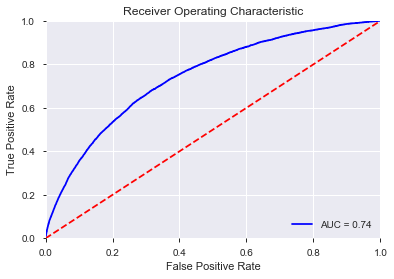

In [135]:
fpr, tpr, threshold = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
preds = []
for x in y_pred[:,1]:
    if x >0.5:
        preds.append(1)
    else:
        preds.append(0)
preds = np.array(preds)


from sklearn.metrics import classification_report
print(classification_report (y_test, preds))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.49      0.01      0.01      7447

   micro avg       0.92      0.92      0.92     92253
   macro avg       0.71      0.50      0.49     92253
weighted avg       0.89      0.92      0.88     92253



In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}


Confusion matrix, without normalization
[[84711    95]
 [ 7438     9]]


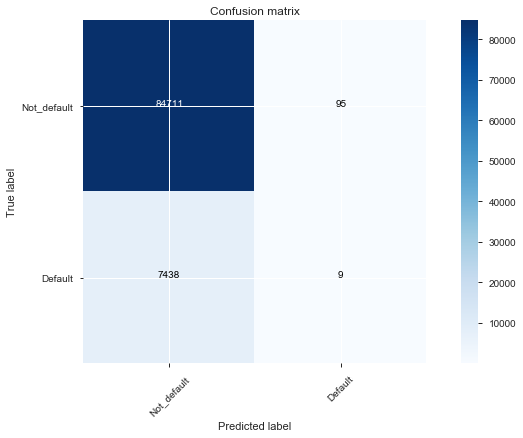

In [88]:
cnf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Not_default', 'Default'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

# Если вглянуть на отчет по полноте и точности, то можно понять, в чем может быть потенцильный рост модели.
# Сейчас очень большой процент ошибки первого рода, что грозит компании невыплатами по кредитам
# Как и предполагали - модель из за дисбаланса классов Модель хорошо научилась предсказывать 0 (если cutt-of = 0.5). Дальнейшие шаги: сабсэмплинг



# В принципе, из за того, что был взят один датасет из всех - метрика неплохая получилась.
# Потенциально в остальных датасетах можно посмореть кредитную нагрузку для каждой заявки, а также историю предыдущих кредитов

Text(0.5, 0, 'Relative Importance')

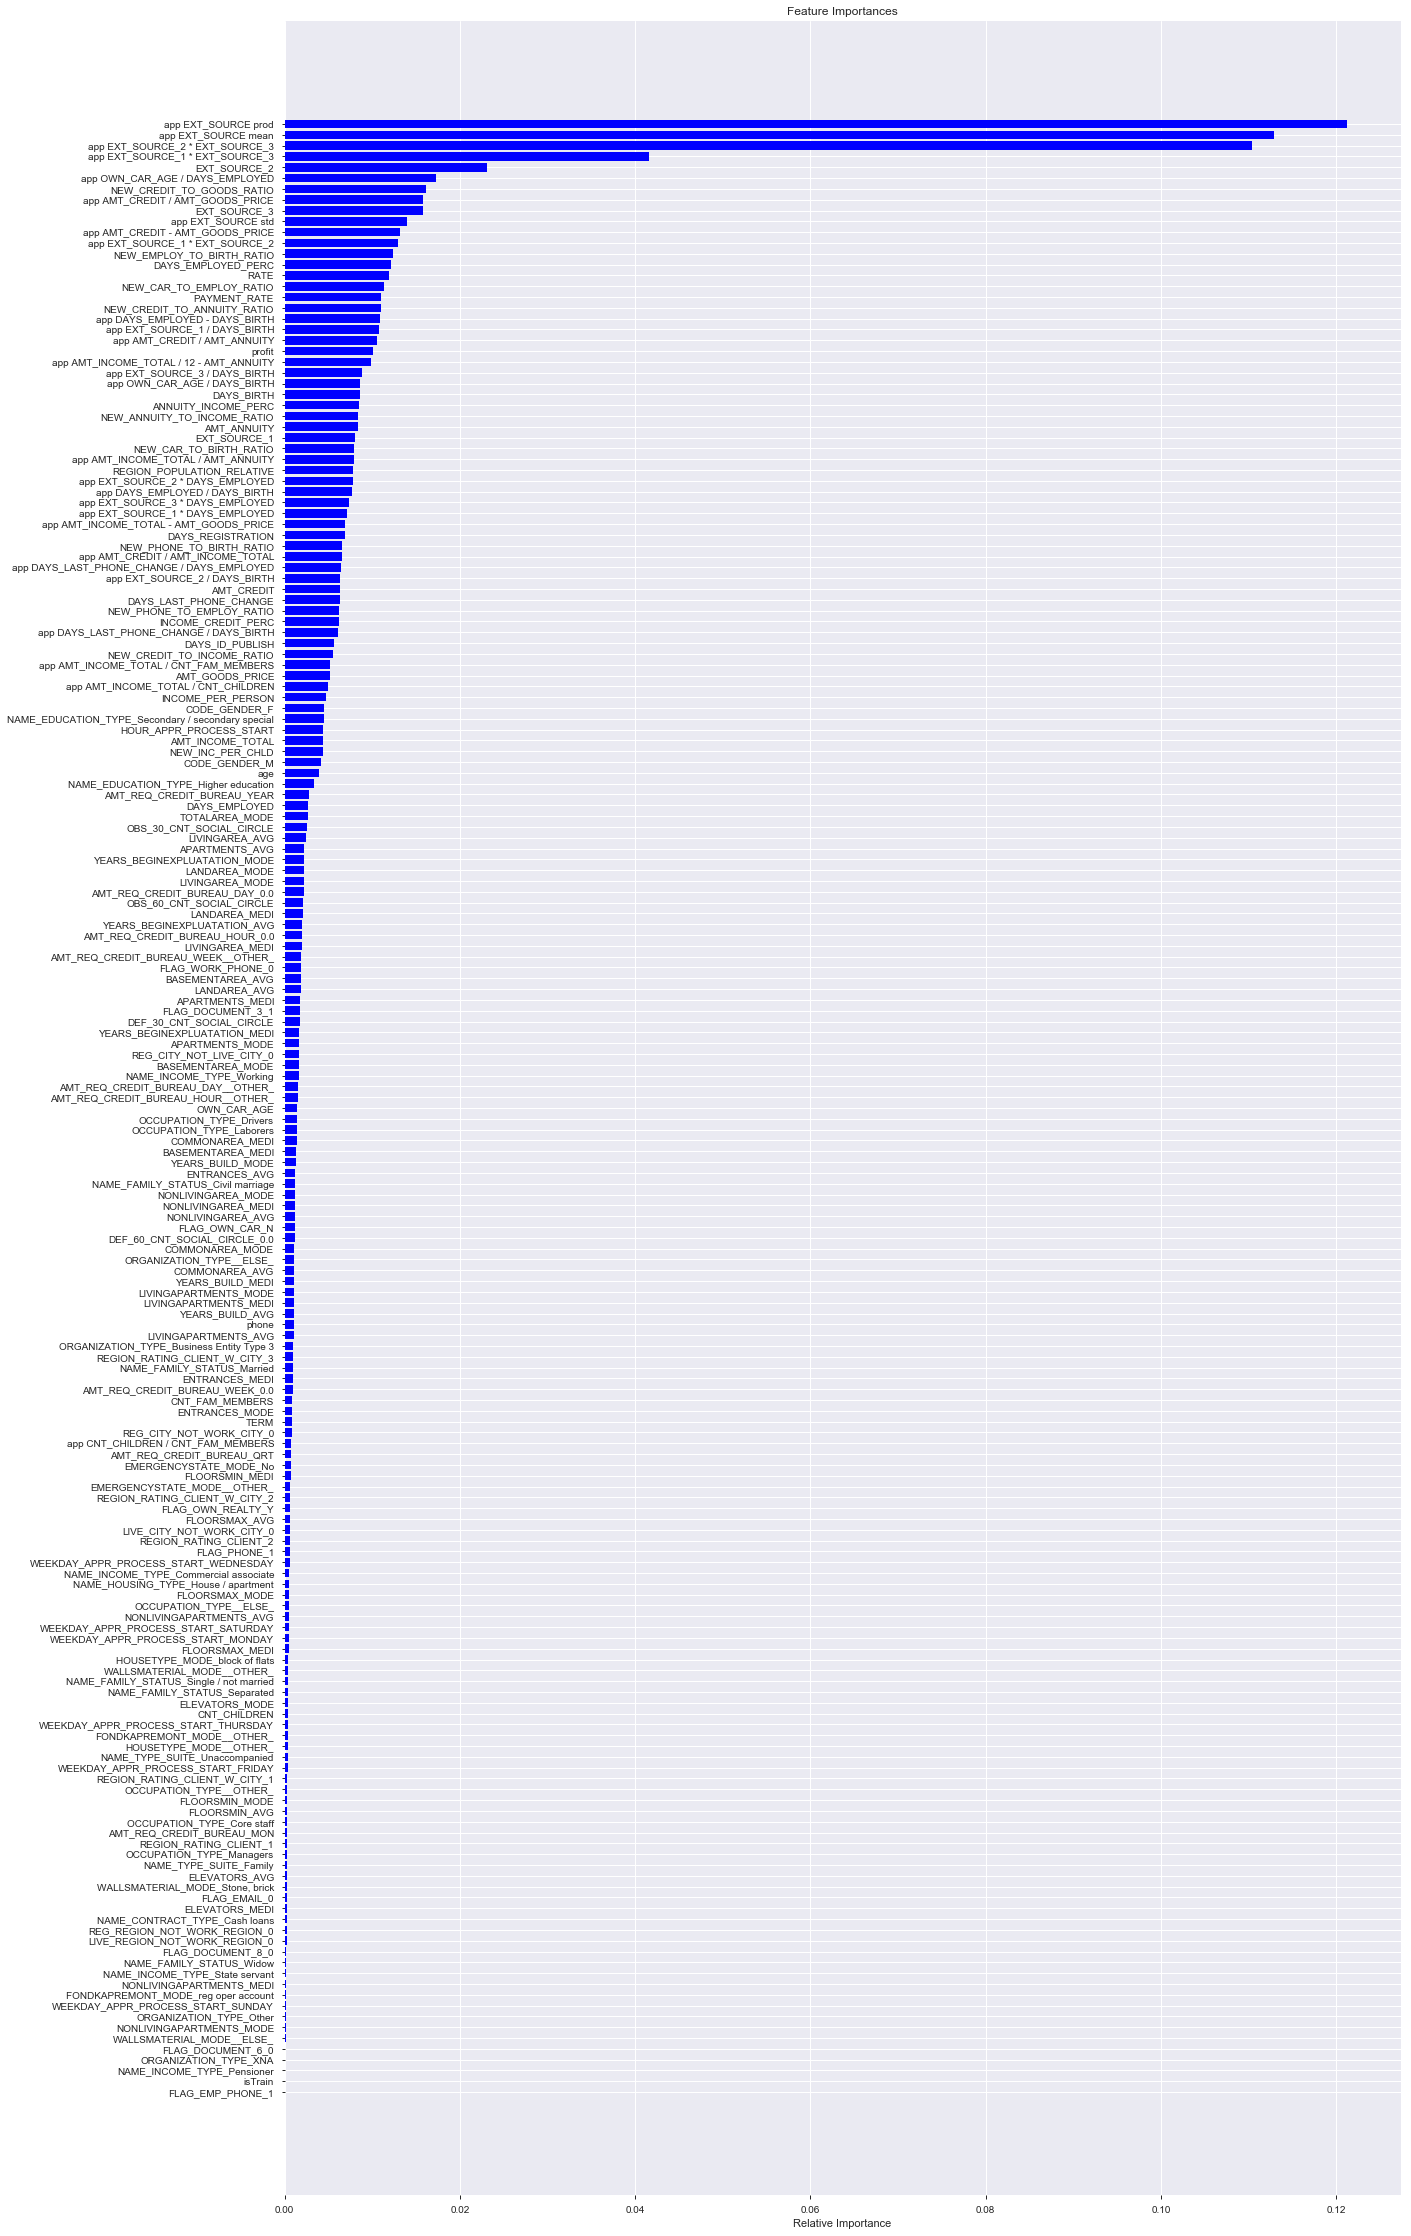

In [99]:
# Посмотрим на важность фичей
features=x_train.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,40))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')


## в топе фичи, которые мы создали, по всей видимости это скоры из БКИ или других моделй, что в принципе объясняет их важность

## из варинтов что можно еще сделать без источников - это протестировать без коррекляционных фич и убрав не важные по FI фичи.
## вероятно модель не сильно потеряет в качестве, зато будет более стабильная и понятная

In [136]:
# Подгтовим сабмит
# Обучаем модель на полных данных и предсказываем

clf.fit(df_application_train, y)
y_pred = clf.predict_proba(df_application_test)

C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


In [148]:
# Пишем сабмит в файл
df_submit['TARGET'] = y_pred[:,1]
df_submit.head()
df_submit.to_csv('submit.csv',index= False)

C:\Users\Vpotapov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


col_name,SK_ID_CURR,TARGET
307511,100001,0.047747
307512,100005,0.115646
307513,100013,0.017771
307514,100028,0.040564
307515,100038,0.123021


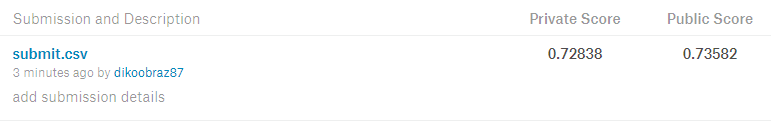

## Скор очень хорошо совпал с кросс валидацией. Что говорит о том, что модель работает стабильно
##  В топе скор 0.8 предполагаю, что за счет использования всех данных, а также бэгинга нескольких моделей